In [1]:
!git clone -b week10 https://github.com/vamsigp/EVA5/

Cloning into 'EVA5'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 501 (delta 65), reused 69 (delta 25), pack-reused 379
Receiving objects: 100% (501/501), 47.48 MiB | 19.27 MiB/s, done.
Resolving deltas: 100% (260/260), done.


In [2]:
%cd EVA5/trainer

/content/EVA5/trainer


In [3]:
!pip install -U albumentations

     |████████████████████████████████| 122kB 4.0MB/s 
     |████████████████████████████████| 952kB 7.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=7f4eeb892a026c2b6f984d87dc70434e6fa7dcff529029417f3289ba2b125ac8
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
%matplotlib inline

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from config import ModelConfig
from data_engine import DataEngine
from trainer import Trainer
from results import *
from utils import *

In [6]:
from Albumentations import *
from GradCAM import *

In [7]:
# from models.cifar10 import cifar10Model
from models.resnet import ResNet18
from models.resnet_lr import ResNet18LR

In [8]:
transform_album = album_compose()

In [9]:
# View model config
args = ModelConfig(transform_album)
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 128,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1,
  'train_transform': <Albumentations.album_compose object at 0x7fc7b289ce80>}

CUDA Available


In [16]:
data = DataEngine(args)

# # get some random training images
# dataiter = iter(data.train_loader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images[:4]))
# # print labels
# print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
device = which_device()
# model = ResNet18().to(device)

# show_model_summary(model, device, (3,32,32))

In [12]:
!pip install torch-lr-finder

In [13]:
# from torch_lr_finder import LRFinder
# from torch.optim.lr_scheduler import ReduceLROnPlateau

In [14]:
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim


def get_best_lr_sgd(model, trainloader, lr=1e-7, momentum=0.9, end_lr=100, num_iter=100):
    """
    Tweaked version from fastai
    
    Increases the learning rate in an exponential manner and computes the training loss for each learning rate. 
    lr_finder.plot() plots the training loss versus logarithmic learning rate.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(trainloader, end_lr=end_lr, num_iter=num_iter)
    lr_finder.plot() # to inspect the loss-learning rate graph
    return lr_finder

/content/EVA5/trainer/models/resnet_lr.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.51E-01


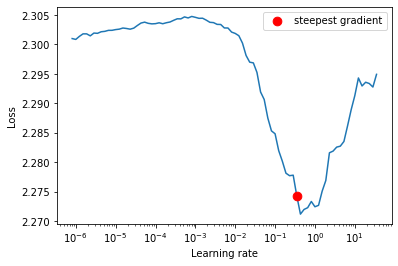

In [18]:
model_lr = ResNet18LR().to(device)

get_best_lr_sgd(model_lr, data.train_loader)

In [ ]:
# for i in range(1,16):
#   model = ResNet18().to(device)
#   criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
  
#   lr_finder = LRFinder(model, optimizer, criterion, device=device)
#   lr_finder.range_test(data.train_loader, end_lr=100, num_iter=100, step_mode="exp")
#   lr_finder.plot()
#   lr_finder.reset()



LR - 3.51 is suggested more number of times (mode)

In [19]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

In [20]:
model = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=6.58E-02, momentum=0.9, weight_decay=0.001)

# scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=20)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [21]:
trainer = Trainer(model, 
                  device,
                  train_loader=data.train_loader, 
                  test_loader = data.test_loader, 
                  optimizer = optimizer, 
                  loss_func = criterion, 
                  lr_scheduler = scheduler) 

In [ ]:
# (train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)

  0%|          | 0/391 [00:00<?, ?it/s]


Current EPOCH: 0
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=3.1443493366241455 Batch_id=390 Accuracy=28.98: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 3264/10000 (32.64%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.015533942091464996

Current EPOCH: 1
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=2.5725064277648926 Batch_id=390 Accuracy=37.99: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 3184/10000 (31.84%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.01744848471879959

Current EPOCH: 2
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=2.405320167541504 Batch_id=390 Accuracy=45.52: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 3803/10000 (38.03%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.014172397887706757

Current EPOCH: 3
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.8747177124023438 Batch_id=390 Accuracy=49.99: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 5038/10000 (50.38%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.010925426387786865

Current EPOCH: 4
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=2.07014799118042 Batch_id=390 Accuracy=53.42: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 5423/10000 (54.23%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.010042022955417633

Current EPOCH: 5
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.710950255393982 Batch_id=390 Accuracy=55.45: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 5740/10000 (57.40%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.010519347882270814

Current EPOCH: 6
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.405103325843811 Batch_id=390 Accuracy=56.58: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 5416/10000 (54.16%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.01166248381137848

Current EPOCH: 7
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.53416907787323 Batch_id=390 Accuracy=58.09: 100%|██████████| 391/391 [03:13<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6365/10000 (63.65%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.008024462646245956

Current EPOCH: 8
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.553206443786621 Batch_id=390 Accuracy=58.94: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 6277/10000 (62.77%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.008678786283731461

Current EPOCH: 9
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.577775478363037 Batch_id=390 Accuracy=59.21: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 5671/10000 (56.71%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.01085412729382515

Current EPOCH: 10
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.3938668966293335 Batch_id=390 Accuracy=60.13: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6604/10000 (66.04%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.00795398746728897

Current EPOCH: 11
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.2762831449508667 Batch_id=390 Accuracy=59.85: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 5541/10000 (55.41%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.010669974935054779

Current EPOCH: 12
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.271730661392212 Batch_id=390 Accuracy=60.45: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 6195/10000 (61.95%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.009233149969577789

Current EPOCH: 13
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.3913460969924927 Batch_id=390 Accuracy=60.82: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6368/10000 (63.68%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.00857714318037033

Current EPOCH: 14
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.4337626695632935 Batch_id=390 Accuracy=60.97: 100%|██████████| 391/391 [03:12<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6491/10000 (64.91%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.007921859234571458

Current EPOCH: 15
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.2749598026275635 Batch_id=390 Accuracy=61.24: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6148/10000 (61.48%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.008838316810131072

Current EPOCH: 16
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.3238420486450195 Batch_id=390 Accuracy=61.53: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6685/10000 (66.85%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.007486081171035767

Current EPOCH: 17
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.3493186235427856 Batch_id=390 Accuracy=61.68: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5610/10000 (56.10%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.010643570333719253

Current EPOCH: 18
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.3245331048965454 Batch_id=390 Accuracy=61.71: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6742/10000 (67.42%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.007359891259670258

Current EPOCH: 19
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.3268827199935913 Batch_id=373 Accuracy=61.86:  96%|█████████▌| 374/391 [03:04<00:08,  2.04it/s]

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

In [ ]:
trainer.classwise_acc(classes)

In [ ]:
misclassified_imgs = trainer.get_misclassified()

In [ ]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_images1.png")

In [ ]:
from results import plot_metrics
plot_metrics(train_loss, train_acc, test_loss, test_acc)

In [ ]:
### GradCam

In [ ]:
dataiter = iter(data.test_loader)
images, labels = dataiter.next()

In [ ]:
import PIL
import numpy as np

In [ ]:
# model.convblock

In [ ]:
for name, layer in model.named_modules():
  if isinstance(layer, torch.nn.Conv2d):
    print(name, layer)

In [ ]:
def plot_images_gradcam(torch_img,normed_torch_img, model):
    images=[]
    g1 = GradCAM(model, model.layer1)
    g2 = GradCAM(model, model.layer2)
    g3 = GradCAM(model, model.layer3)
    g4 = GradCAM(model, model.layer4)
    mask1, _ = g1(normed_torch_img)
    mask2, _ = g2(normed_torch_img)
    mask3, _ = g3(normed_torch_img)
    mask4, _ = g4(normed_torch_img)
    heatmap1, result1 = visualize_cam(mask1, torch_img)
    heatmap2, result2 = visualize_cam(mask2, torch_img)
    heatmap3, result3 = visualize_cam(mask3, torch_img)
    heatmap4, result4 = visualize_cam(mask4, torch_img)

    images.extend([torch_img.cpu(), heatmap1, heatmap2, heatmap3, heatmap4])
    images.extend([torch_img.cpu(), result1, result2, result3, result4])
    grid_image = make_grid(images, nrow=5)
    imshow(grid_image)

In [ ]:
trans = transforms.ToPILImage()
pil_img=trans(torchvision.utils.make_grid(images[1]))
torch_img,normed_torch_img=change(pil_img,device)
plot_images_gradcam(torch_img,normed_torch_img, model)